In [197]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
import numpy as np
import sklearn
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
%load_ext Cython
import cython
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
pd.set_option('mode.chained_assignment', None)
#cython: boundscheck=False, wraparound=False, nonecheck=False
from sklearn.utils.class_weight import compute_sample_weight
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
pd.options.display.expand_frame_repr = False
it = iter(jt.get_themes())
theme = next(it)
print("Current Theme: ", theme)
#set_nb_theme(theme)
#ocean / chesterish

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
Current Theme:  chesterish


In [166]:
def timetoclass(row):
    dt_obj1 = parser.parse(row['rundate'])
    dt_obj2 = parser.parse(row['stopdate'])
    ans = ((dt_obj2-dt_obj1).total_seconds()+3600/2)//3600
    if ans == 24:
        ans = 23
    return ans

def timedif(row):
    dt_obj1 = parser.parse(row['rundate'])
    dt_obj2 = parser.parse(row['stopdate'])
    return (dt_obj2-dt_obj1).total_seconds()/60

def intime(row):
    dt_obj1 = parser.parse(row['indate'].split()[0]+' 00:00:00')
    dt_obj2 = parser.parse(row['indate'])
    return (dt_obj2-dt_obj1).total_seconds()/3600

def indatetime(row, start):
    dt_obj1 = parser.parse(start)
    dt_obj2 = parser.parse(row['indate'])
    return (dt_obj2-dt_obj1).total_seconds()/3600

def load_bases(paths, date, plotting=False, names=None):
    pd.set_option('display.max_columns', None)  # or 1000
    pd.set_option('display.max_rows', None)  # or 1000
    pd.set_option('display.max_colwidth', 100)  # or 199
    pd.options.display.expand_frame_repr = False
    dfs = [0]*len(paths)
    for i in range(len(paths)):
        dfs[i] = pd.read_csv(paths[i],error_bad_lines=False, sep=";")
        dfs[i]['stopdate'].replace('', np.nan, inplace=True)
        dfs[i].dropna(subset=['stopdate'], inplace=True)
        dfs[i]["exec"] = dfs[i].apply (lambda row: timetoclass(row), axis=1)
        dfs[i]["exec_min"] = dfs[i].apply (lambda row: timedif(row), axis=1)
        dfs[i]["intime"] = dfs[i].apply (lambda row: intime(row), axis=1)
        dfs[i]["indatetime"] = dfs[i].apply (lambda row: indatetime(row, dfs[i]['indate'].min()), axis=1)
        dfs[i] = dfs[i].loc[dfs[i]['ntime']<=1440]
        dfs[i] = dfs[i].loc[dfs[i]['nproc']<=2000]
        dfs[i] = dfs[i].loc[dfs[i]['exec_min']<=dfs[i]['ntime']]
        if plotting:
            plt.rcParams['figure.dpi'] = 200
            plt.rcParams['savefig.dpi'] = 200
            ax1 = plt.subplot(221+i)
            sns.distplot(dfs[i]['exec']).set_title("Distribution of exec in "+names[i])
            ax1.set_xlim(0, 25)
            plt.show()
    return dfs

def plot_cmdline_stats(dfs, names):    
    fig, axs = plt.subplots(len(paths), 1, figsize=(5,10))
    fig.tight_layout(pad=5.0)
    for i in range(len(paths)):
        df = dfs[i]
        cmds = {}
        for s in df['cmdline']:
            cnt = len(s.split())
            if cnt not in cmds:
                cmds[cnt] = 1
            else:
                cmds[cnt] += 1
        s_cmds = {c:cmds[c] for c in sorted(cmds)}
        axs[i].bar([f'{i}' for i in s_cmds.keys()], s_cmds.values(),linewidth=100)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("кол-во задач")
        axs[i].set_xlabel("кол-во параметров")
    plt.show()
    
def cmd_keys_stats(dfs, names):
    for k in range(len(dfs)):
        df = dfs[k]
        cmds = {}
        cmd_list = df['cmdline'].tolist()
        for i in range(len(cmd_list)):
            s = cmd_list[i]
            local_list = []
            for ss in s.split():
                for sss in ss.split('/'):
                    if sss != '':
                        local_list.append(sss)
            for j in range(len(local_list)-1):
                if local_list[j] is None or len(local_list[j])==0:
                    continue
                if local_list[j][0] == '-' and local_list[j+1][0] != '-':
                    local_list[j] = local_list[j]+" "+local_list[j+1]
                    #print(local_list[j])
                    local_list[j+1] = None

            for sss in local_list:
                if sss is None:
                    continue
                if sss not in cmds:
                    cmds[sss] = 1
                else:
                    cmds[sss] += 1
        s_cmds ={k: v for k, v in sorted(cmds.items(), key=lambda item: -item[1]) if cmds[k] > 200 and not "home" in k and not "pstorage" in k and '' != k and '.'!=k} 
        print(names[k])
        print(s_cmds)
        print('\n')

        
def unique_cmd_stat(dfs, names):
    fig, axs = plt.subplots(len(paths), 1, figsize=(5,10))
    fig.tight_layout(pad=5.0)
    s_cmds_arr = []
    for i in range(len(dfs)):
        df = dfs[i]
        cmds = {}
        for index, row in df.iterrows():
                uid = row['userid']
                if uid not in cmds:
                    cmds[uid] = [row['cmdline']]
                else:
                    cmds[uid].append(row['cmdline'])
        s_cmds ={k: v for k, v in sorted(cmds.items(), key=lambda item: -len(item[1]))} 
        s_cmds_arr.append(s_cmds)
        for x in s_cmds:
            print(x, " - ", len(s_cmds[x]), " - ", len(set(s_cmds[x])))
        v1 = [ len(set(s_cmds[x])) for x in s_cmds]
        v2 = [ len(s_cmds[x]) - len(set(s_cmds[x])) for x in s_cmds]
        v1,v2 = v1[:40], v2[:40]

        axs[i].bar([i for i in range(len(v1))], v1 ,linewidth=100, label = "Уникальне команды")
        axs[i].bar([i for i in range(len(v1))], v2, bottom=v1 ,linewidth=100,  label = "Повторные команды")
        axs[i].set_title(names[i])
        axs[i].set_ylabel("кол-во пусков")
        axs[i].set_xlabel("пользователь")
        axs[i].legend()
    return s_cmds_arr

def vif_stat(dfs, names):
    for k in range(len(dfs)):
        df = dfs[k]
        df = df.drop(columns=['indate','taskname', 'exittype', 'cmdline', 'rundate', 'stopdate', 'userid', 'indatetime'])
        df = df.dropna()
        df = df._get_numeric_data()
        # VIF dataframe
        vif_data = pd.DataFrame()
        vif_data["feature"] = df.columns
        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                                  for i in range(len(df.columns))]
        print(names[k], vif_data)

def normalize_data(dfs, names = None, plotting=True):
    new_dfs = []
    for k in range(len(dfs)):
        df = dfs[k]
        dfdel = df.loc[df['ntime'] - df['exec_min'] <= 0.05]
        df = df.loc[df['ntime'] - df['exec_min'] > 0.05]
        df = df.sort_values(by=['indate'])
        df = df.drop(columns=['indate', 'rundate', 'stopdate', 'exittype', 'exec_min', 'taskname', 'indatetime'])

        col_to_dict = ['userid', 'gid', 'orgid']
        dicts = {'userid':{}, 'gid':{}, 'orgid':{}}
        for col in col_to_dict:
            for d in df[col]:
                if d in dicts[col]:
                    dicts[col][d]+=1
                else:
                    dicts[col][d]=1
            df[col] = [list(dicts[col]).index(d) for d in df[col]]

        col_to_norm = ['nproc','ntime','userid','gid','orgid','intime']
        for col in col_to_norm:
            colmin = df[col].min()
            colmax = df[col].max()
            if col in ['ntime']:
                dfdel.loc[:, col] = (dfdel[col] - colmin) / (colmax - colmin)
            df.loc[:, col] = (df[col] - colmin) / (colmax - colmin)
        new_dfs.append(df)
        # probability plot
        if plotting:
            plt.rcParams['figure.dpi'] = 200
            plt.rcParams['savefig.dpi'] = 200
            plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=1.5)
            if names is None:
                names = ['_']*len(dfs)
            ax1 = plt.subplot(21 + 100*len(dfs)+ 2*k)
            sns.distplot(df['exec']).set_title(f"Distribution of exec in {names[k]}")
            ax1 = plt.subplot(22 + 100*len(dfs)+ 2*k)
            res = scipy.stats.probplot(df['exec'], plot=plt)
            #ax1 = plt.subplot(43 + 100*len(dfs)+ 4*k)
            #sns.distplot(df['nproc']).set_title("Distribution of nproc")
            #ax1 = plt.subplot(44 + 100*len(dfs)+ 4*k)
            #res = scipy.stats.probplot(df['nproc'], plot=plt)
            
            
            plt.figure()
            plt.scatter(df['exec'], df['ntime'], s=5, label='Отобранные данные')
            plt.scatter(dfdel['exec'], dfdel['ntime'], s=5, c='red', label='Неподходящие данные')
            plt.ylabel('Запрошенное время(нормированное)', fontsize=12)
            plt.xlabel('Время выполнения(час)', fontsize=12)
            plt.legend(loc='lower right')
            
            
    return new_dfs

def prepare_cmd_data(dfs, plotting=False):
    cmd_data = []
    global_keys = []
    global_names = []
    for df in dfs:
        X = df.drop(columns=['exec'])
        program_data = ['']*len(X['cmdline'])
        cmd_dict = {"cmd_{}".format(i+1):([-1]*len(X['cmdline'])) for i in range(20)}
        keys = set()
        program_names = set()
        key_table = [[]]*len(X['cmdline'])
        for ii, s in enumerate(X['cmdline']):
            pas = False
            k = []
            program_name = s.split(' ')[0].split('/')[-1]
            program_names.add(program_name)
            for idx, ss in enumerate(s.split()):
                if pas:
                    pas = False
                    continue
                if ss[0]=='-' and idx<len(s.split())-1 and s.split()[idx+1][0]!='-':
                    keys.add(ss+' '+s.split()[idx+1])
                    k.append(ss+' '+s.split()[idx+1])
                    pas = True
                else:
                    keys.add(ss)
                    k.append(ss)
            #print(ii)
            key_table[ii] = k
            program_data[ii] = program_name
        keys = list(keys)
        program_names = list(program_names)
        #print(program_names)
        cmd_table = np.zeros((len(X['cmdline']), len(keys)), dtype=np.int32)
        for idx, ss in enumerate(key_table):
            program_data[idx] = program_names.index(program_data[idx])
            #for s in ss:
                #cmd_table[idx][keys.index(s)] = 1
            key_list = []
            for k in range(len(ss)):
                key_list.append(keys.index(ss[k]))
            key_list = sorted(key_list, reverse=True)
            #print(key_list)
            for k in range(len(key_list)):
                cmd_dict["cmd_{}".format(k+1)][idx]=key_list[k]
            
        for i in range(20):
            s = "cmd_{}".format(i+1)
            X[s] = cmd_dict[s]
        X['program_names'] = program_data
        X = X.drop(columns=['cmdline'])
        X = X.astype(np.float64)
        cmd_data.append(X)
        global_keys.append(keys)
        global_names.append(program_names)
    return cmd_data, global_keys, global_names

def generate_train_test_data(dfs,cmd_data, test_percent = 0.25):
    X_trains, X_tests, y_trains, y_tests = [],[],[],[]
    for i in range(len(dfs)):
        df = dfs[i]
        print(len(df))
        X = cmd_data[i]
        y = df.loc[:,['userid', 'exec']]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, shuffle=True,random_state=3)#, stratify=y

        userdict = {}
        for u in X_train['userid']:
            if u in userdict:
                userdict[u]+=1
            else:
                userdict[u]=1

        for u in X_test['userid']:
            if u not in userdict:
                userdict[u]=0

        X_trains.append(X_train.loc[[userdict[user] > 3 for user in X_train['userid']]])
        X_tests.append(X_test.loc[[userdict[user] > 3 for user in X_test['userid']]])
        y_train = y_train.loc[[userdict[user] > 3 for user in y_train['userid']]]
        y_test = y_test.loc[[userdict[user] > 3 for user in y_test['userid']]]
        y_tests.append(y_test.drop(columns=['userid']))
        y_trains.append(y_train.drop(columns=['userid']))
    return X_trains, X_tests, y_trains, y_tests

In [167]:
user_idx = 2
group_idx = 3
org_idx = 4
cmd_idx = 5
intime_idx = 6
i = 0
def custom_metric(X1, X2, **kwargs):
    au = kwargs["au"]
    ag = kwargs["ag"]
    ao = kwargs["ao"]
    d = 0
    if X1[user_idx]!=X2[user_idx]:
        d+=au
    if X1[group_idx]!=X2[group_idx]:
        d+=ag
    if X1[org_idx]!=X2[org_idx]:
        d+=ao
    for idx in range(2):
            dif = (X1[idx] - X2[idx])**2
            d+=dif
    d+=(X1[intime_idx] - X2[intime_idx])**2
    d += sum(abs(cmd_table[int(X1[cmd_idx])] - cmd_table[int(X2[cmd_idx])]))/len(cmd_table[0])
            
    return d

In [168]:
"""
%%cython --annotate -n custom_metric_c
from libc.math cimport abs
from libc.stdio cimport printf
from libc.stdlib cimport malloc, free


def cython_f(double[:] X1, double[:] X2, int p = 2, double w = -1):
    cdef double d = 0
    cdef double dif = 0
    cdef root_w = 1
    if w != -1:
        root_w = sqrt(w)
    for idx in range(6):
        dif = (root_w*(X1[idx] - X2[idx]))**2
        d+=dif
    dif = 0
    for i in range(6,6+20):
        for j in range(6,6+20):
            if (X1[i] == X2[j]):
                continue;
            if X1[i] > X2[j] or j == 25:
                dif+=1
                continue;
    d+=dif/1000
    return sqrt(d)
"""

'\n%%cython --annotate -n custom_metric_c\nfrom libc.math cimport abs\nfrom libc.stdio cimport printf\nfrom libc.stdlib cimport malloc, free\n\n\ndef cython_f(double[:] X1, double[:] X2, int p = 2, double w = -1):\n    cdef double d = 0\n    cdef double dif = 0\n    cdef root_w = 1\n    if w != -1:\n        root_w = sqrt(w)\n    for idx in range(6):\n        dif = (root_w*(X1[idx] - X2[idx]))**2\n        d+=dif\n    dif = 0\n    for i in range(6,6+20):\n        for j in range(6,6+20):\n            if (X1[i] == X2[j]):\n                continue;\n            if X1[i] > X2[j] or j == 25:\n                dif+=1\n                continue;\n    d+=dif/1000\n    return sqrt(d)\n'

In [169]:
%%writefile cython_metric.pyx
from libc.math cimport sqrt, abs
from libc.stdio cimport printf
from libc.stdlib cimport malloc, free

cdef int* cmd_table
cdef int cmd_table_len
cdef int cmd_table_h
cdef int user_idx = 2
cdef int group_idx = 3
cdef int org_idx = 4
cdef int intime_idx = 5

def cython_metric(double[:] X1, double[:] X2, int p = 2, double w = -1):
    cdef double d = 0
    cdef double dif = 0
    cdef root_w = 1
    if w != -1:
        root_w = sqrt(w)
    for idx in range(6):
        dif = (root_w*(X1[idx] - X2[idx]))**2
        d+=dif
    dif = 0
    for i in range(6,6+20):
        for j in range(6,6+20):
            if (X1[i] == X2[j]):
                break;
            if X1[i] > X2[j] or j == 25:
                dif+=1
                break;
    d+=dif*(d/100)
    return sqrt(d)


Overwriting cython_metric.pyx


In [170]:
%%writefile cython_metric_v2.pyx
from libc.math cimport sqrt, abs
from libc.stdio cimport printf
from libc.stdlib cimport malloc, free

cdef int* cmd_table
cdef int cmd_table_len
cdef int cmd_table_h
cdef int user_idx = 2
cdef int group_idx = 3
cdef int org_idx = 4
cdef int intime_idx = 5

def cython_metric_v2(double[:] X1, double[:] X2, int p = 2, double w = -1):
    cdef double d = 0
    cdef double dif = 0
    cdef root_w = 1
    if w != -1:
        root_w = sqrt(w)
    for idx in range(6):
        dif = (root_w*(X1[idx] - X2[idx]))**2
        d+=dif
    
    if X1[user_idx]!=X2[user_idx]:
        d+=1
        
    dif = 0   
    for i in range(6,6+20):
        for j in range(6,6+20):
            if (X1[i] == X2[j]):
                break;
            if X1[i] > X2[j] or j == 25:
                dif+=1
                break;
    d+=(dif/100)
    return sqrt(d)

Overwriting cython_metric_v2.pyx


In [171]:
%%writefile minkovski_metric.pyx
from libc.math cimport sqrt, abs
from libc.stdio cimport printf
from libc.stdlib cimport malloc, free

cdef int* cmd_table
cdef int cmd_table_len
cdef int cmd_table_h
cdef int user_idx = 2
cdef int group_idx = 3
cdef int org_idx = 4
cdef int intime_idx = 5

def minkovski_metric(double[:] u, double[:] v, int p = 2, double w = -1):
    cdef double d = 0
    cdef root_w = 1
    if w != -1:
        root_w = sqrt(w)
    for idx in range(6):
        d+=(root_w*(u[idx]-v[idx]))**2
    return sqrt(d)

Overwriting minkovski_metric.pyx


In [172]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(name="cython_metric", ext_modules=cythonize('cython_metric.pyx'))
#setup(name="minkovski_metric", ext_modules=cythonize('minkovski_metric.pyx'))
setup(name="cython_metric_v2", ext_modules=cythonize('cython_metric_v2.pyx'))

Overwriting setup.py


In [173]:
!python setup.py build_ext --inplace

Compiling cython_metric.pyx because it changed.
[1/1] Cythonizing cython_metric.pyx
running build_ext
building 'cython_metric' extension
"C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.30.30705\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -IC:\Users\alexm\anaconda3\include -IC:\Users\alexm\anaconda3\Include "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.30.30705\ATLMFC\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.30.30705\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.8\include\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.19041.0\\shared" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.19041.0\\um" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.19041.0\\winrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.19041.0\\cppwinrt" /Tccython_metric.c /Fobuild\temp.

C:\Users\alexm\anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\alexm\Desktop\Проект\Diplom\cython_metric.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
error: could not delete 'cython_metric.cp39-win_amd64.pyd': Отказано в доступе


In [174]:
from cython_metric import cython_metric
from minkovski_metric import minkovski_metric
#train_d = X_train.drop(columns=["cmd_{}".format(i+1) for i in range(20)])
#z = train_d.values[:2]
#print(z[0], z[1])
def python_metric( X1,  X2,  p = 2,  w = -1):
    d = 0
    dif = 0
    root_w = 1
    if w != -1:
        root_w = sqrt(w)
    for idx in range(6):
        dif = (root_w*(X1[idx] - X2[idx]))**2
        d+=dif
    dif = 0
    for i in range(6,6+20):
        for j in range(6,6+20):
            if (X1[i] == X2[j]):
                break;
            if X1[i] > X2[j] or j == 25:
                dif+=1
                break;
    print(dif)
    d+=dif/1000
    return d

In [175]:
from cython_metric import cython_metric
from minkovski_metric import minkovski_metric
from cython_metric_v2 import cython_metric_v2
ridge_param = {
    'alpha': [ 0.6, 0.7, 0.75, 0.8, 0.9],
    'fit_intercept':[True, False],
    'normalize':[True, False],
    'solver':['svd'],
    'class_weight':[None, 'balanced']
}

tree_param = {
    "splitter":["best","random"],
    "max_depth" : [10, 15, 20, 25,30,35,40,45, 50],
    "min_samples_leaf":[2,3,4,5,6,7,8,9,10],
    "criterion": ['entropy', 'gini'],
    "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
    }

knn_param_no_cmd = {
    "algorithm":['ball_tree', 'brute'],
    "n_neighbors":[4, 8, 12,16,20, 24],
    #'metric':[minkovski_metric],
    "weights":['uniform', 'distance'],
}

knn_param = {
    "algorithm":['ball_tree', 'brute'],
    "n_neighbors":[4, 8, 12,16,20,24],
    'metric':[cython_metric],
    "weights":['uniform', 'distance'],
    }
knnv2_param = {
    "algorithm":['ball_tree', 'brute'],
    "n_neighbors":[4, 8, 12,16,20, 24],
    'metric':[cython_metric_v2],
    "weights":['uniform', 'distance'],
    }

In [183]:
def prepare_program_trees(X_trains,y_trains,cmd_data, glob_keys, glob_prog_names):
    program_trees_global = []
    for i in range(len(dfs)):
        program_trees = {}
        df = X_trains[i].join(y_trains[i])
        keys = glob_keys[i]
        prog_names = glob_prog_names[i]
        for name in prog_names:
            df_prog = df.loc[df['program_names'] == prog_names.index(name)]
            if df_prog.shape[0] >= 0.03*df.shape[0]:
                local_key_d = {}
                df_prog = df_prog.reset_index() 
                for index, row in df_prog.iterrows():
                    for k in range(1,21):
                        key = row["cmd_{}".format(k)]
                        if key in local_key_d.keys():
                            local_key_d[key] += 1
                        else:
                            local_key_d[key] = 1
                keys_to_check = list(local_key_d.keys())
                for key in keys_to_check:
                    if local_key_d[key] < 0.03*df_prog.shape[0]:
                        del local_key_d[key]
                tree_test_data = df_prog.loc[:, ["cmd_{}".format(k) for k in range(1,21)] + ["exec"]]
                for j in range(len(local_key_d)):
                    tree_test_data[f"t_cmd_{j}"] = tree_test_data.apply(lambda row: 0 if list(local_key_d.keys())[j] not in [row["cmd_{}".format(k)] for k in range(1,21)] else 1,  axis=1)
                tree_test_data = tree_test_data.drop(columns= ["cmd_{}".format(k) for k in range(1,21)])
                tree_test_data = tree_test_data.loc[sum([tree_test_data[f"t_cmd_{j}"] for j in range(len(local_key_d))]) > 0]
                print(tree_test_data.describe(), name, df_prog.shape[0], len(local_key_d))
                
     
def to_binary_level(l, X_trains, X_tests, y_trains, y_tests):# l format: (left, middle, right)
    new_X_trains, new_X_tests, new_y_trains, new_y_tests = [],[],[],[]
    todel= [[]]*len(X_trains)
    for i in range(len(X_trains)):
        X_train, X_test, y_train, y_test = X_trains[i], X_tests[i], y_trains[i], y_tests[i]
        X_train=pd.concat([X_train]*2)
        y_train=pd.concat([y_train]*2)
        X_test=pd.concat([X_test]*4)
        y_test=pd.concat([y_test]*4)
        xy_train = X_train.join(y_train)
        xy_train = xy_train.loc[(xy_train["exec"]>=l[0]) & (xy_train["exec"]<l[2])]
        if len(xy_train) == 0:
            todel[i].append(l)
        xy_train["exec"] = xy_train.apply(lambda x: 1 if x["exec"]>=l[1] else 0, axis=1)
        new_X_trains.append(xy_train.iloc[:,:-1])
        new_y_trains.append(xy_train.loc[:,["exec"]])
        
        xy_test = X_test.join(y_test)
        xy_test = xy_test.loc[(xy_test["exec"]>=l[0]) & (xy_test["exec"]<l[2])]
        xy_test["exec"] = xy_test.apply(lambda x: 1 if x["exec"]>=l[1] else 0, axis=1)
        new_X_tests.append(xy_test.iloc[:,:-1])
        new_y_tests.append(xy_test.loc[:,["exec"]])
        
    return new_X_trains, new_X_tests, new_y_trains, new_y_tests, todel

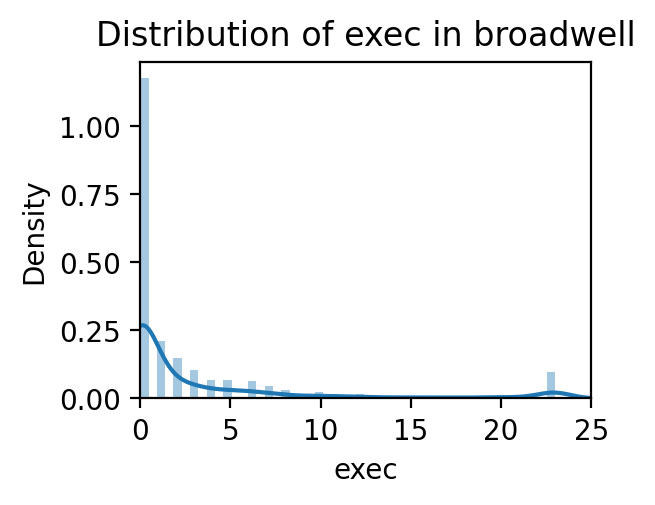

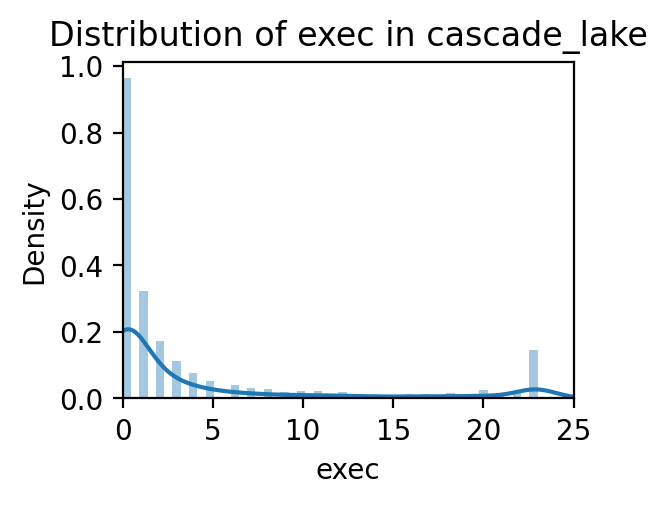

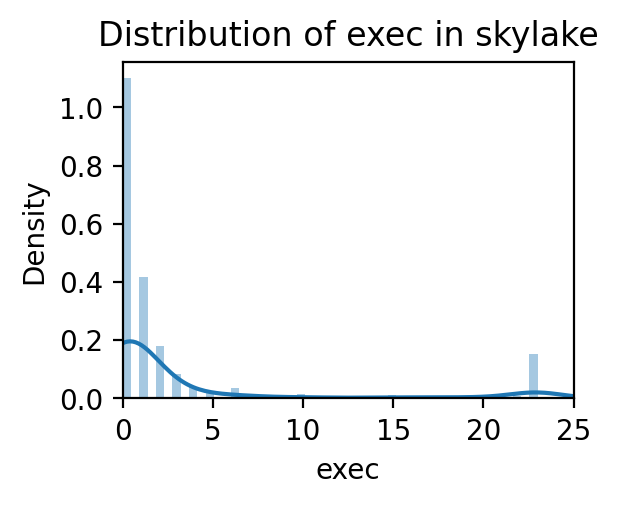

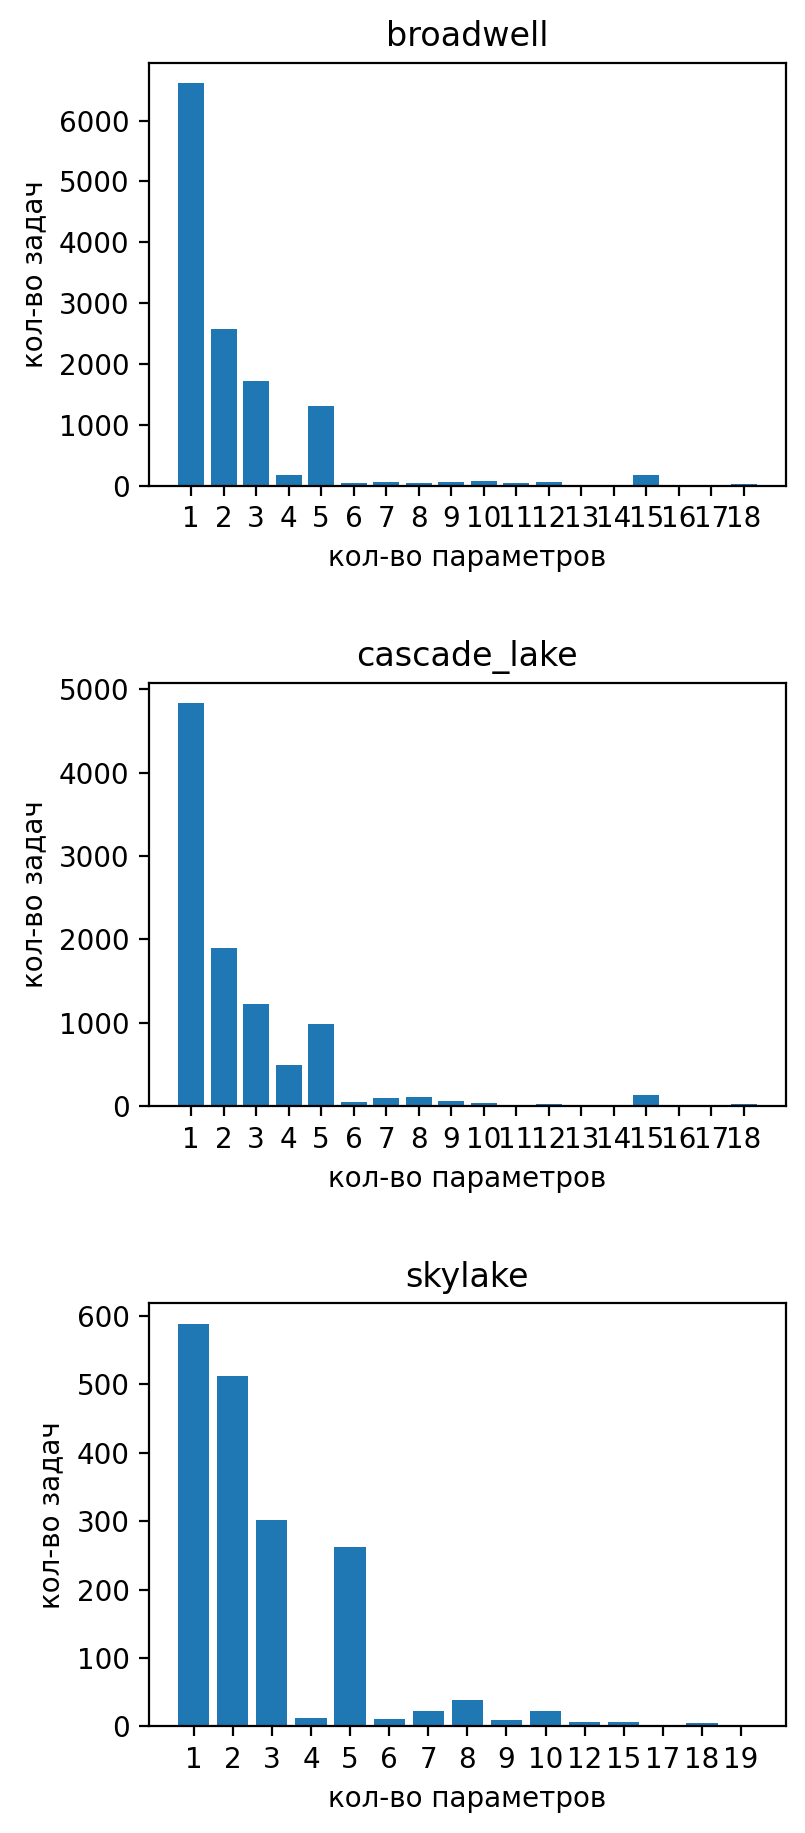

broadwell
{'aizel': 2718, 'vasp_std': 2498, '..': 2301, 'bin': 2198, 'calc': 1895, 'oivt23': 1812, 'znt': 1812, 'vasp': 1635, 'soft': 1181, 'photon1': 1081, 'lmp_intel_cpu_intelmpi': 1023, 'oivt21': 932, 'orca-run': 921, 'iofran3': 778, 'iofran1': 761, 'runorca': 720, 'hppi1': 696, 'vasp.6.1.0': 694, 'phys1': 682, 'ti72_nb22_zr6': 677, 'vvp': 660, 'vasp.5.4.4': 608, 's.pavlov': 602, 'pw.x': 599, '1': 577, 'dlpoly.x': 560, 'free_energy': 557, 'bin_intel_2021': 539, 'icad4': 531, 'work': 531, '4': 531, 'bin_vasp': 529, 'test': 518, 'ibhf7': 511, 'glebushek': 511, 'vasp6': 511, 'chph15': 510, '3d': 503, 'calypso_test': 478, 'submit.sh': 460, 'outfile_300.txt': 423, 'oivt20': 396, 'priroda': 390, 'omp': 350, 'p_mvs10p': 338, 'p_mvs10q': 333, 'lammps': 332, 'g16.sh': 328, 'ti67_nb15_zr18': 322, 'sasha': 300, 'oivt5': 297, 'gubanov': 297, 'icp3': 274, 'tasks': 274, 'chph13': 272, '0': 271, 'oivt3': 261, 'tgalia': 260, '2': 259, 'kgtu9': 258, 'klimkov': 256, 'pic_2d_openmp': 253, 'bin_vasp_6.

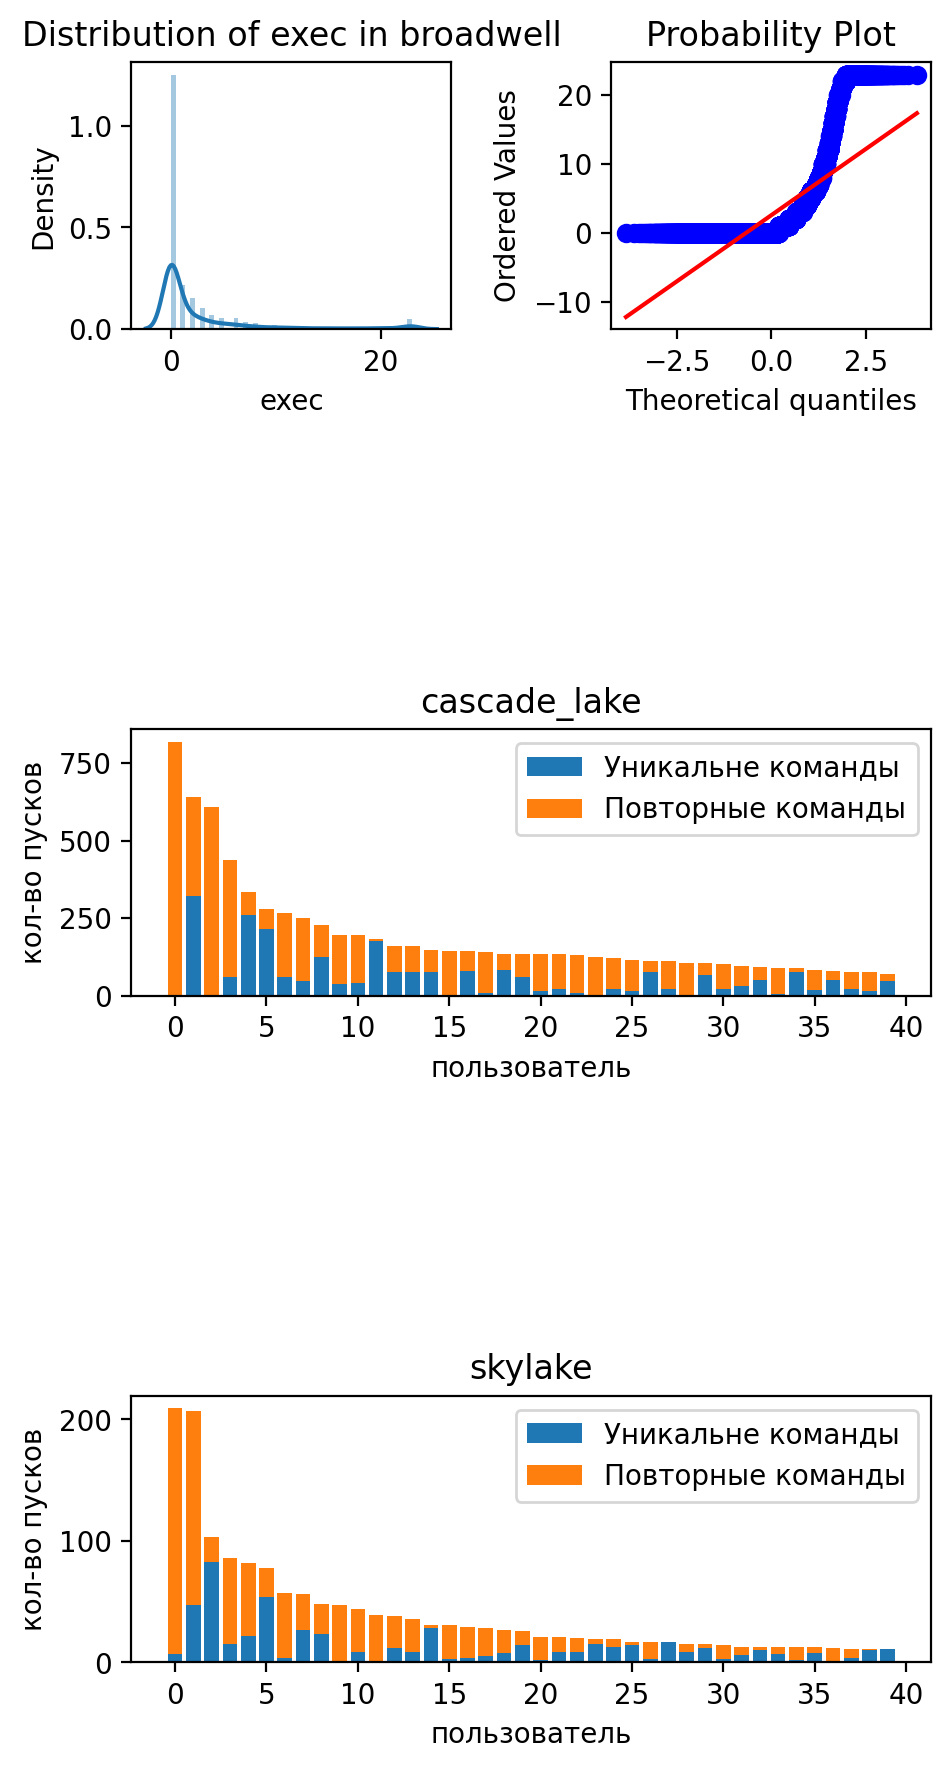

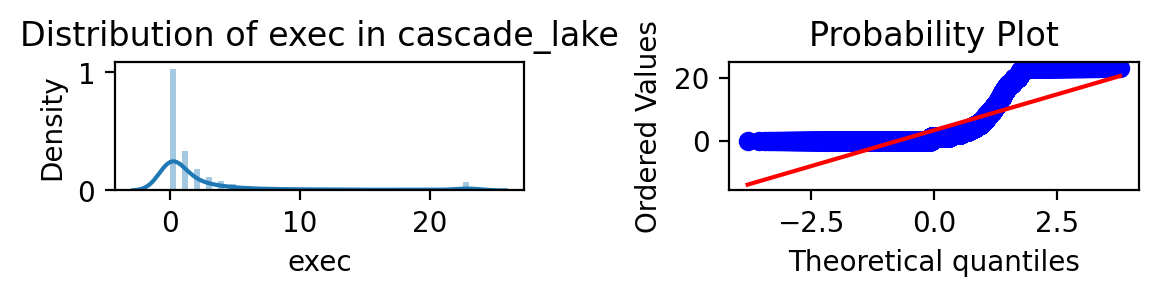

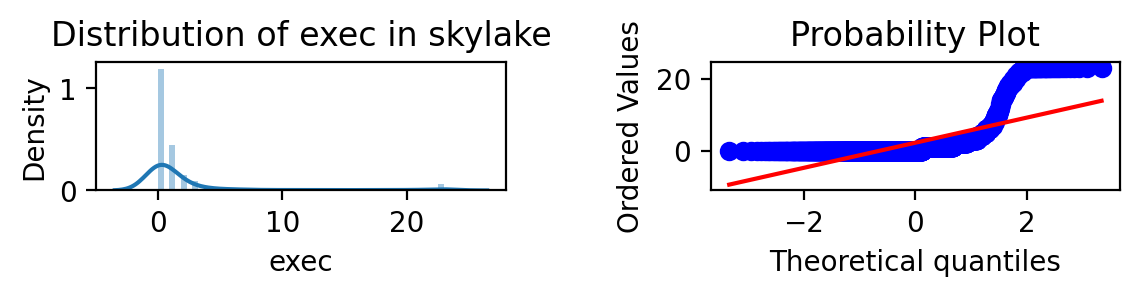

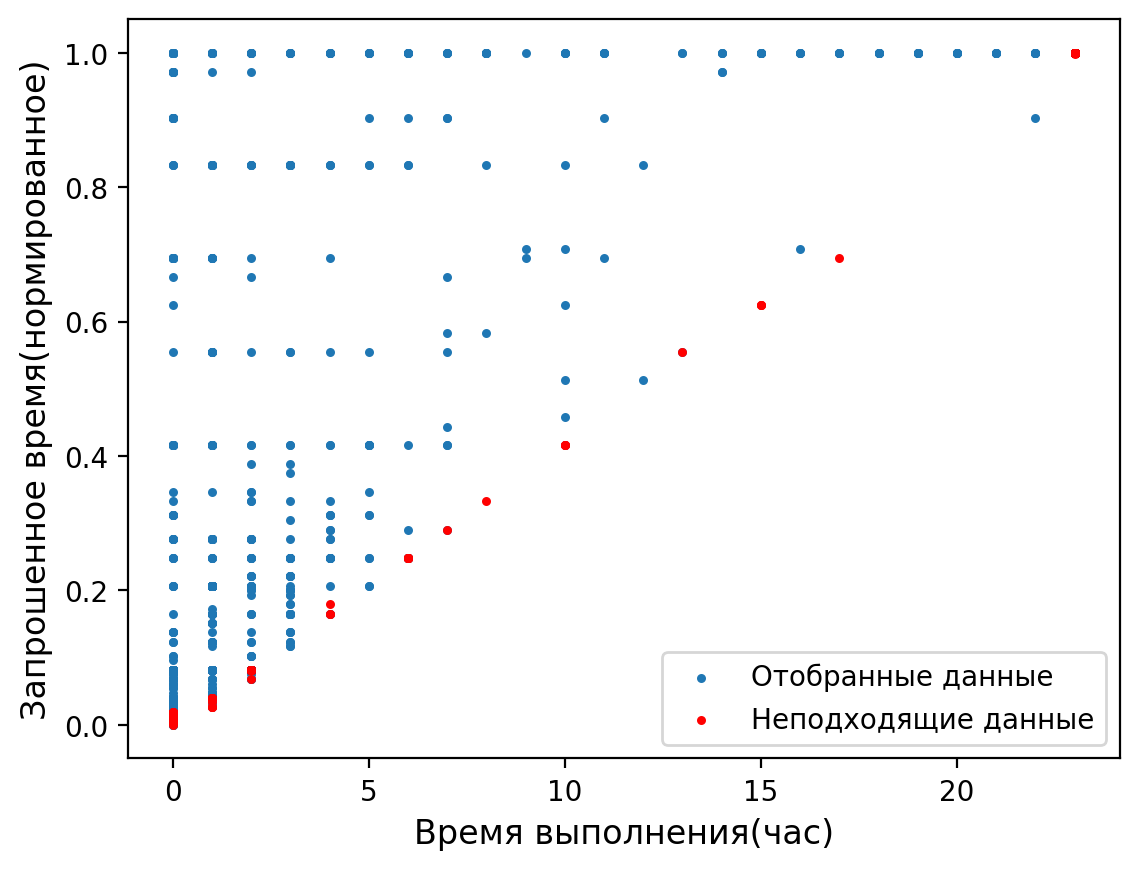

In [177]:
date = "04_04_23"
paths = [".\\run_info\\broadwell_"+date+".csv", ".\\run_info\\cascade_lake_"+date+".csv", ".\\run_info\\skylake_"+date+".csv"]
names = ["broadwell", "cascade_lake", "skylake"]
dfs = load_bases(paths, date, plotting=True, names=names)
plot_cmdline_stats(dfs, names)
cmd_keys_stats(dfs, names)
s_cmds_arr = unique_cmd_stat(dfs, names)
vif_stat(dfs, names)
dfs = normalize_data(dfs, names=names, plotting=True)#, plotting=False
cmd_data, keys, prog_names = prepare_cmd_data(dfs)

In [178]:
def train_and_find_best(dfs,names,models,params, X_trains, X_tests, y_trains, y_tests, logging= False, skip_names = []):
    best_models = {}
    total_results = {}
    outputs = {}
    for i in range(len(dfs)):
        if names[i] in skip_names:
            continue
        X_train, X_test, y_train, y_test = X_trains[i], X_tests[i], y_trains[i], y_tests[i]
        #program_trees = program_trees_global[i]
        w = compute_sample_weight(class_weight='balanced', y=y_train)
        y_w = y_train['exec'].values.tolist()
        if logging:
            print("weights: ", w, y_w)
        #real_weights = [w[y_w.index(i)] for i in range(24)]
        output = {}
        best_model = {}
        results = {}
        #w = compute_sample_weight(class_weight='balanced', y=y_train)
        for m in models:
            train_data = X_train
            test_data = X_test
            #if m == 'tree':
            #    train_data = program_k_decision(train_data, program_trees)
            if m!='knn' and m!="knnv2":
                train_data = train_data.drop(columns=["cmd_{}".format(i+1) for i in range(20)])
                test_data = test_data.drop(columns=["cmd_{}".format(i+1) for i in range(20)])
            #print(train_data.describe())
            cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
            #search = RandomizedSearchCV(models[m], params[m], scoring='accuracy', n_jobs=-1, cv=cv, n_iter=30)
            search = GridSearchCV(models[m], params[m], scoring='f1_weighted', n_jobs=-1, cv=cv)
            if m.find('knn') < 0:
                result = search.fit(train_data, y_train,sample_weight=w)
            else:
                result = search.fit(train_data, y_train)
            best = search.best_estimator_
            best_model[m] = best
            output[m] = best.predict(test_data)
            results[m] = result
            if logging:
                print(names[i], m)
                print('Best Score: %s' % result.best_score_)
                print('Best Hyperparameters: %s' % result.best_params_)
        total_results[names[i]] = results
        outputs[names[i]] = output
        best_models[names[i]] = best_model
    return best_models, outputs, total_results

In [179]:
def choose_best(result, model_dict):
    best_m = None
    best_r = 0
    for m in model_dict:
        if result[m].best_score_ > best_r:
            best_r = result[m].best_score_
            best_m = m
    return best_m

def print_report(y,out,average='binary', weights=None):
    print(classification_report(y['exec'], out, digits=4))
    print("Accuracy ", accuracy_score(y['exec'], out))
    print("F1 ", f1_score(y['exec'], out, average=average,sample_weight=weights))
    
def report(dfs, names, level, models, y_tests, outputs, results, print_all = False, skip_names = []):
    print (f"--------------LEVEL-{level}--------------")
    for i in range(len(dfs)):
        if names[i] in skip_names:
            continue
        print(names[i])
        y = y_tests[i]
        x = range(len(y['exec']))
        out = outputs[names[i]]
        result = results[names[i]]
        best_m = choose_best(result,models[names[i]])
        print(f'--------{best_m}--------')
        w = compute_sample_weight(class_weight='balanced', y=y)
        print_report(y, out[best_m], average="weighted",weights=w )
        
        if print_all:
            for m in models:    
                if m != best_m:
                    print(f'--------{m}--------')
                    print_report(y, out[m])

In [180]:
"""X_trains, X_tests, y_trains, y_tests = generate_train_test_data(dfs, cmd_data, test_percent = 0.25)
models = {
    'knn':KNeighborsClassifier(),
    'knnv2':KNeighborsClassifier(),
    'knn without cmd':KNeighborsClassifier(),
}
params = {
    'knn' : knn_param,
    'knnv2' : knnv2_param,
    'knn without cmd' : knn_param_no_cmd,
}"""

"X_trains, X_tests, y_trains, y_tests = generate_train_test_data(dfs, cmd_data, test_percent = 0.25)\nmodels = {\n    'knn':KNeighborsClassifier(),\n    'knnv2':KNeighborsClassifier(),\n    'knn without cmd':KNeighborsClassifier(),\n}\nparams = {\n    'knn' : knn_param,\n    'knnv2' : knnv2_param,\n    'knn without cmd' : knn_param_no_cmd,\n}"

In [184]:
X_trains, X_tests, y_trains, y_tests = generate_train_test_data(dfs, cmd_data, test_percent = 0.1)
models = {
    #'knn':KNeighborsClassifier(),
    #'knnv2':KNeighborsClassifier(),
    'ridge':RidgeClassifier(),
    'tree':tree.DecisionTreeClassifier(),
    'knn without cmd':KNeighborsClassifier(),
}

params = {
    'knn' : knn_param,
    'knnv2' : knnv2_param,
    'ridge': ridge_param,
    'tree': tree_param,
    'knn without cmd' : knn_param_no_cmd,
}

levels = [(0,1,24),(1,5,24),(1,3,5),(1,2,3),(3,4,5),(5,23,24),(5,13,23),(5,9,13),
             (5,7,9),(5,6,7),(7,8,9),(9,11,13),(9,10,11),(11,12,13),(13,19,23),
             (13,16,19),(13,14,16),(14,15,16),(16,17,19),(17,18,19),(19,21,23),(19,20,21),(21,22,23)]

levels_v2 = [(0,1,24),(1,6,24),(1,3,6),(1,2,3),(3,4,6),(4,5,6),(6,19,24),(6,13,19),(6,9,13),
             (6,7,9),(7,8,9),(9,11,13),(9,10,11),(11,12,13),
             (13,16,19),(13,14,16),(14,15,16),(16,17,19),(17,18,19),(19,22,24),(19,21,22),(19,20,21),
             (22,23,24)]
levels=levels_v2
level_models = {}
level_results = {}
skip_names = []#'cascade_lake','skylake']
l_to_del = {names[i]:[] for i in range(len(names))}

for l in levels:
    X_trains_l, X_tests_l, y_trains_l, y_tests_l, todel = to_binary_level(l, X_trains, X_tests, y_trains, y_tests)
    for i in range(len(names)):
            if len(todel[i]) != 0:
                l_to_del[names[i]].append(l)
    
    #print(l, y_tests_l[0].describe(),y_trains_l[0].describe(),end='\n\n\n')
    #program_trees_global = prepare_program_trees(X_trains,y_trains ,cmd_data, keys, prog_names)
    #"""
    best_models_l, outputs_l, total_results_l = train_and_find_best(dfs,names,models, params, X_trains_l, X_tests_l, y_trains_l, y_tests_l, skip_names = skip_names)
    report(dfs, names, l, best_models_l, y_tests_l, outputs_l, total_results_l, skip_names = skip_names)
    level_models[l] = best_models_l
    level_results[l] = total_results_l
    #"""
#X_trains[0].join(y_trains[0]).head(10)
#X_tests[1].describe()

11710
9031
1632


C:\Users\alexm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.98092727 0.99814026 0.9008715  0.99790186 0.90775355 0.99790186
 0.890255   0.99790186 0.88765104 0.99790186 0.88236964 0.99790186
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.96693321 0.99579405 0.85574669 0.99455671 0.86921849 0.99455671
 0.84438062 0.99455671 0.83933838 0.99455671 0.82969486 0.99455671
        nan        nan        nan        nan 0.86909634        nan
        nan 0.99455671        nan        nan        nan 0.99455671]
  warnings.warn(


--------------LEVEL-(0, 1, 24)--------------
broadwell
--------knn without cmd--------
              precision    recall  f1-score   support

           0     0.8963    0.8858    0.8910     10928
           1     0.8405    0.8545    0.8474      7696

    accuracy                         0.8729     18624
   macro avg     0.8684    0.8701    0.8692     18624
weighted avg     0.8732    0.8729    0.8730     18624

Accuracy  0.872852233676976
F1  0.8701020302676943
cascade_lake
--------knn without cmd--------
              precision    recall  f1-score   support

           0     0.8100    0.7973    0.8036      7184
           1     0.8000    0.8125    0.8062      7168

    accuracy                         0.8049     14352
   macro avg     0.8050    0.8049    0.8049     14352
weighted avg     0.8050    0.8049    0.8049     14352

Accuracy  0.8049052396878483
F1  0.8049024688531853
skylake
--------knn without cmd--------
              precision    recall  f1-score   support

           0    

C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------LEVEL-(6, 19, 24)--------------
broadwell
--------knn without cmd--------
              precision    recall  f1-score   support

           0     0.8509    0.8151    0.8326      1904
           1     0.5111    0.5750    0.5412       640

    accuracy                         0.7547      2544
   macro avg     0.6810    0.6951    0.6869      2544
weighted avg     0.7654    0.7547    0.7593      2544

Accuracy  0.7547169811320755
F1  0.6906030276247
cascade_lake
--------knn without cmd--------
              precision    recall  f1-score   support

           0     0.9167    0.8609    0.8879      1840
           1     0.5556    0.6897    0.6154       464

    accuracy                         0.8264      2304
   macro avg     0.7361    0.7753    0.7516      2304
weighted avg     0.8439    0.8264    0.8330      2304

Accuracy  0.8263888888888888
F1  0.773603199013905
skylake
--------knn without cmd--------
              precision    recall  f1-score   support

           0     1

C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------LEVEL-(7, 8, 9)--------------
broadwell
--------tree--------
              precision    recall  f1-score   support

           0     0.4667    0.7000    0.5600       160
           1     0.8571    0.6923    0.7660       416

    accuracy                         0.6944       576
   macro avg     0.6619    0.6962    0.6630       576
weighted avg     0.7487    0.6944    0.7087       576

Accuracy  0.6944444444444444
F1  0.6961493513217668
cascade_lake
--------knn without cmd--------
              precision    recall  f1-score   support

           0     0.6667    0.8889    0.7619       144
           1     0.8571    0.6000    0.7059       160

    accuracy                         0.7368       304
   macro avg     0.7619    0.7444    0.7339       304
weighted avg     0.7669    0.7368    0.7324       304

Accuracy  0.7368421052631579
F1  0.7389988652124587
skylake
--------tree--------
              precision    recall  f1-score   support

           0     1.0000    0.5000    0

C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------LEVEL-(9, 11, 13)--------------
broadwell
--------tree--------
              precision    recall  f1-score   support

           0     0.6000    0.6000    0.6000       240
           1     0.5714    0.5714    0.5714       224

    accuracy                         0.5862       464
   macro avg     0.5857    0.5857    0.5857       464
weighted avg     0.5862    0.5862    0.5862       464

Accuracy  0.5862068965517241
F1  0.5856297203510933
cascade_lake
--------knn without cmd--------
              precision    recall  f1-score   support

           0     0.6250    0.6818    0.6522       352
           1     0.5882    0.5263    0.5556       304

    accuracy                         0.6098       656
   macro avg     0.6066    0.6041    0.6039       656
weighted avg     0.6080    0.6098    0.6074       656

Accuracy  0.6097560975609756
F1  0.6016589147956387
skylake
--------tree--------
              precision    recall  f1-score   support

           0     0.5000    0.5000   

C:\Users\alexm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [1.  1.  1.  1.  0.8 1.  0.4 1.  nan nan nan nan 1.  1.  1.  1.  0.8 1.
 0.4 1.  nan nan nan nan]
  warnings.warn(
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision an

--------------LEVEL-(11, 12, 13)--------------
broadwell
--------tree--------
              precision    recall  f1-score   support

           0     0.6667    0.7500    0.7059       128
           1     0.6000    0.5000    0.5455        96

    accuracy                         0.6429       224
   macro avg     0.6333    0.6250    0.6257       224
weighted avg     0.6381    0.6429    0.6371       224

Accuracy  0.6428571428571429
F1  0.6190476190476186
cascade_lake
--------tree--------
              precision    recall  f1-score   support

           0     0.6667    0.5000    0.5714       192
           1     0.4000    0.5714    0.4706       112

    accuracy                         0.5263       304
   macro avg     0.5333    0.5357    0.5210       304
weighted avg     0.5684    0.5263    0.5343       304

Accuracy  0.5263157894736842
F1  0.535121328224776
skylake
--------ridge--------
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000   

C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_cla

--------------LEVEL-(14, 15, 16)--------------
broadwell
--------tree--------
              precision    recall  f1-score   support

           0     0.3333    0.6667    0.4444        48
           1     0.5000    0.2000    0.2857        80

    accuracy                         0.3750       128
   macro avg     0.4167    0.4333    0.3651       128
weighted avg     0.4375    0.3750    0.3452       128

Accuracy  0.375
F1  0.4007050528789664
cascade_lake
--------tree--------
              precision    recall  f1-score   support

           0     0.3750    0.7500    0.5000        64
           1     0.5000    0.1667    0.2500        96

    accuracy                         0.4000       160
   macro avg     0.4375    0.4583    0.3750       160
weighted avg     0.4500    0.4000    0.3500       160

Accuracy  0.4
F1  0.407969639468691
skylake
--------tree--------
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        16

    accuracy        

C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------LEVEL-(19, 22, 24)--------------
broadwell
--------tree--------
              precision    recall  f1-score   support

           0     0.7778    0.6364    0.7000       176
           1     0.8710    0.9310    0.9000       464

    accuracy                         0.8500       640
   macro avg     0.8244    0.7837    0.8000       640
weighted avg     0.8453    0.8500    0.8450       640

Accuracy  0.85
F1  0.7788994696239153
cascade_lake
--------tree--------
              precision    recall  f1-score   support

           0     0.8000    0.6667    0.7273       192
           1     0.7895    0.8824    0.8333       272

    accuracy                         0.7931       464
   macro avg     0.7947    0.7745    0.7803       464
weighted avg     0.7938    0.7931    0.7894       464

Accuracy  0.7931034482758621
F1  0.771856462121948
skylake
--------tree--------
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        16
       

In [185]:
best_level_models = {}
for level in level_models:
    for dataset in level_models[level]:
        best_m = choose_best(level_results[level][dataset], level_models[level][dataset])
        best_level_models[(level,dataset)] = level_models[level][dataset][best_m]
best_level_models

{((0, 1, 24),
  'broadwell'): KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, weights='distance'),
 ((0, 1, 24),
  'cascade_lake'): KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, weights='distance'),
 ((0, 1, 24),
  'skylake'): KNeighborsClassifier(algorithm='brute', n_neighbors=4, weights='distance'),
 ((1, 6, 24),
  'broadwell'): KNeighborsClassifier(algorithm='brute', n_neighbors=4, weights='distance'),
 ((1, 6, 24),
  'cascade_lake'): KNeighborsClassifier(algorithm='brute', n_neighbors=4, weights='distance'),
 ((1, 6, 24),
  'skylake'): KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, weights='distance'),
 ((1, 3, 6),
  'broadwell'): KNeighborsClassifier(algorithm='brute', n_neighbors=4, weights='distance'),
 ((1, 3, 6),
  'cascade_lake'): KNeighborsClassifier(algorithm='brute', n_neighbors=4, weights='distance'),
 ((1, 3, 6),
  'skylake'): KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, weights='distance'),
 ((1, 2, 3),
  'broadwell'): K

In [186]:
def predict_by_tree(TC, test):
    x = test.copy().drop(columns=["cmd_{}".format(i+1) for i in range(20)])
    x["answer"] = x.apply(lambda z: TC.predict([z]), axis=1)
    return x

class Node:
    def __init__(self, segment, classificator):
        self.segment=segment
        self.classificator=classificator
        self.left = None
        self.right = None
    def __str__(self):
        return str(self.segment)
    def predict(self, data):
        return self.classificator.predict(data)

class tree_classificator:
    def __init__(self, root):
        self.node_list = [root]
        self.root = root
        
    def add_node(self, node):
        cur_n = self.root
        self.node_list.append(node)
        next_n = cur_n
        move_right = False
        while next_n is not None:
            cur_n = next_n
            if cur_n.segment[1]<=node.segment[0]:
                next_n = cur_n.right
                move_right = True
            else:
                next_n = cur_n.left
                move_right = False
        if move_right:
            cur_n.right = node
        else:
            cur_n.left = node
            
    def print_tree(self):
        nlist = [self.root]
        flag = True
        while flag:
            flag = False
            new_list = []
            print([str(n) for n in nlist])
            for n in nlist:
                if n is not None:
                    new_list.append(n.left)
                    new_list.append(n.right)
                    flag = True
                else:
                    new_list.append(None)
                    new_list.append(None)
            nlist = new_list
    
    def predict(self, data):
        cur_n = self.root
        next_n = cur_n
        while next_n is not None:
            cur_n = next_n
            if cur_n.predict(data) == 0:
                next_n = cur_n.left
            else:
                next_n = cur_n.right
        if cur_n.predict(data) == 0:
            return cur_n.segment[0]
        else:
            return cur_n.segment[2]-1
        


In [187]:
for i in range(len(dfs)):
    TC = tree_classificator(Node(levels[0],best_level_models[(levels[0], names[i])]))
    for j in range(1, len(levels)):
        TC.add_node(Node(levels[j],best_level_models[(levels[j], names[i])]))
    #TC.print_tree()
    X_test, y_test = X_tests[i], y_tests[i]
    X_test = predict_by_tree(TC, X_test)
    print_report(y_test, X_test["answer"], average='micro')
    

              precision    recall  f1-score   support

         0.0     0.8963    0.8858    0.8910       683
         1.0     0.5094    0.4821    0.4954       112
         2.0     0.5500    0.6471    0.5946        85
         3.0     0.3958    0.3333    0.3619        57
         4.0     0.3519    0.4222    0.3838        45
         5.0     0.2381    0.2174    0.2273        23
         6.0     0.3235    0.4074    0.3607        27
         7.0     0.1818    0.2000    0.1905        10
         8.0     0.5556    0.1923    0.2857        26
         9.0     0.0000    0.0000    0.0000         9
        10.0     0.0000    0.0000    0.0000         6
        11.0     0.3750    0.3750    0.3750         8
        12.0     0.2222    0.3333    0.2667         6
        13.0     0.3333    0.1429    0.2000         7
        14.0     0.0000    0.0000    0.0000         3
        15.0     0.1667    0.2000    0.1818         5
        16.0     0.1667    0.3333    0.2222         3
        17.0     0.0000    

C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\anaconda3\lib\site-packages\sklearn\metrics\_cla

In [ ]:
s = list(set(X_trains[0]["program_names"]))
pr_d = {si:0 for si in s}
for i, pn in enumerate(X_trains[0]["program_names"]):
    pr_d[pn] += 1
v = sorted(list(pr_d.values()))
v.reverse()
v = list(filter(lambda num: num > len(X_trains[0])*0.03, v))
plt.bar(x=range(len(v)), # start off with the xticks as numbers 0:19
        height=v)
# The plot is now created, and we use Matplotlib style
# commands to enhance the output.
plt.ylabel("Количество запусков")
plt.xlabel("Название прграммы")
plt.title("Распределение запусков")
plt.gca().yaxis.grid(linestyle=':')


In [ ]:
pd.concat([X_trains[0]]*2).describe()

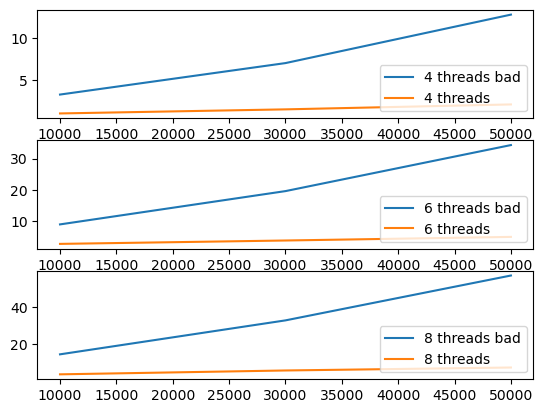

In [3]:
import matplotlib.pyplot as plt
"""
4;10000;3.22734;0.955967;
6;10000;7.01297;1.44669;
4;30000;8.84832;2.57551;
8;10000;12.8428;2.04038;
6;30000;19.5628;3.66508;
4;50000;14.6955;3.90942;
8;30000;34.3788;4.82733;
6;50000;33.0085;5.99033;
8;50000;57.2016;7.59377;
"""
x = [10000, 30000, 50000]

yb = [[3.22734,7.01297, 12.8428],
[8.84832,19.5628, 34.3788],
 [14.6955, 33.0085,57.2016]]

y = [[0.955967, 1.44669,2.04038],
[2.57551, 3.66508, 4.82733],
[3.90942, 5.99033, 7.59377]]
n = [4,6,8]
fig, axs = plt.subplots(nrows= 3 , ncols= 1 )
for i in range(3):
    axs[i].plot(x, yb[i], label=f'{n[i]} threads bad')
    axs[i].plot(x, y[i], label=f'{n[i]} threads')
    axs[i].legend(loc='lower right')
#plt

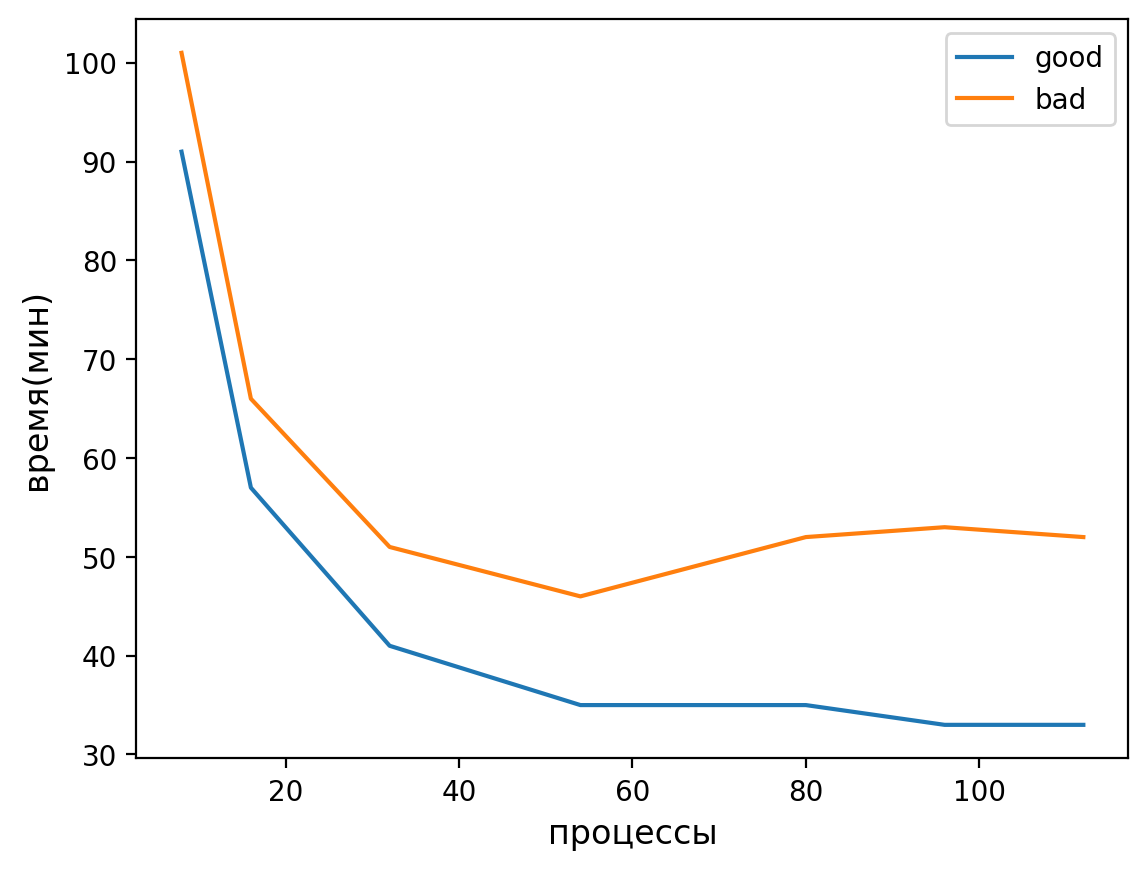

In [192]:

x = [8,16,32,54,80,96,112]
y = [91,57,41,35,35,33,33]
y_b = [101,66,51,46,52,53,52]
plt.plot(x, y,label="good")
plt.plot(x, y_b,label="bad")
plt.ylabel('время(мин)', fontsize=12)
plt.xlabel('процессы', fontsize=12)
plt.legend(loc='upper right')